### TABLE CREATION

In [1]:
import numpy as np
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

from TwoStageClassifier import TwoStageClassifier
from distributionsHelper import visualize_datasets
from featureExtraction import find_best_features_sets
from helper import *
from plotter import plot_features
from smoothingHelper import interpolate_subset_simple_labels, smooth_subset

In [2]:
data_train = pd.read_pickle("DamasconeA24.pkl")
data_validation = pd.read_pickle("DamasconeA4.pkl")
data_test = pd.read_pickle("DamasconeB4.pkl")

# data_train = create_df("DamasconeA/data2/*_CPXE_*.csv", offset=(49, 51), angle=1)
# data_validation = create_df("DamasconeA/data1/*_CPXE_*.csv", offset=(49, 50), angle=-1)
# data_test = create_df("DamasconeB/together/*_CPXE_*.csv", symmetric=True)

In [3]:
# data_validation.to_pickle("DamasconeA4.pkl")
# data_test.to_pickle("DamasconeB4.pkl")
# data_train.to_pickle("DamasconeA24.pkl")

In [4]:
# data_train['stiffness_to_relaxation'] = data_train['Stiffness'] / data_train['force_relaxation']
# data_train['oscillation_to_max_force'] = data_train['force_oscillation'] / data_train['force_max']
#
# data_test['stiffness_to_relaxation'] = data_test['Stiffness'] / data_test['force_relaxation']
# data_test['oscillation_to_max_force'] = data_test['force_oscillation'] / data_test['force_max']
#
# data_validation['stiffness_to_relaxation'] = data_validation['Stiffness'] / data_validation['force_relaxation']
# data_validation['oscillation_to_max_force'] = data_validation['force_oscillation'] / data_validation['force_max']
# data_train = data_train.dropna()
# data_test = data_test.dropna()
# data_validation = data_validation.dropna()

In [5]:
# to_remove = ['poly3_coef0', 'poly3_coef1', 'poly3_coef2', 'poly3_coef3',
#              'poly4_coef0', 'poly4_coef1', 'poly4_coef2', 'poly4_coef3', 'poly4_coef4',
#              'poly5_coef0', 'poly5_coef1', 'poly5_coef2', 'poly5_coef3', 'poly5_coef4',
#              # Segmentation features
#              'segment2_slope', 'segment3_slope', 'segment2_force_std', 'segment3_force_std',
#              'segment2_skew', 'segment3_skew']
# feature_list_3 = feature_list = [x for x in feature_list2 + ['stiffness_to_relaxation', 'oscillation_to_max_force'] if
#                                  x not in to_remove]

feature_list = ['Stiffness', 'Tau', 'Entropy', 'Upstroke', 'Downstroke', 'P_ss', 'time_to_max',
                'force_overshoot', 'force_relaxation', 'force_rms',
                'damping_coefficient', 'contact_area', 'force_ptp', 'load_duration', 'activity',
                'mobility', 'tkeo_mean', 'correlation_fp', 'peak_ratio', 'sample_entropy',
                'loading_skewness', 'loading_kurtosis', 'quartic_coefficient', 'local_mean_Upstroke',
                'local_mean_Tau', 'stiffness_deviation_from_global_median',
                'position_deviation_from_global_median', 'stiffness_z_score', 'position_z_score']

### NaN Handling and Spatial Smoothing

In [6]:
# Fill missing points inside the grid, and single feature values that are NaN
data_test = interpolate_subset_simple_labels(data_test, feature_list)
data_train = interpolate_subset_simple_labels(data_train, feature_list)
data_validation = interpolate_subset_simple_labels(data_validation, feature_list)

print(len(data_validation), len(data_test), len(data_train))

6561 6561 6561


In [7]:
data_train["time_to_max"] = -data_train["time_to_max"]
data_test["time_to_max"] = -data_test["time_to_max"]
data_validation["time_to_max"] = -data_validation["time_to_max"]

data_train["load_duration"] = -data_train["load_duration"]
data_test["load_duration"] = -data_test["load_duration"]
data_validation["load_duration"] = -data_validation["load_duration"]

In [8]:
smoothing_config = {feature: 'median' for feature in feature_list}

# Smooth each subset SEPARATELY
smoothed_test = smooth_subset(data_test, feature_list, smoothing_config)
smoothed_train = smooth_subset(data_train, feature_list, smoothing_config)
smoothed_validation = smooth_subset(data_validation, feature_list, smoothing_config)

### Dataset Splitting


Class distribution in Training set:
Label 0.0: 4609 samples (70.25%)
Label 1.0: 395 samples (6.02%)
Label 2.0: 391 samples (5.96%)
Label 3.0: 379 samples (5.78%)
Label 4.0: 391 samples (5.96%)
Label 5.0: 396 samples (6.04%)

Class distribution in Test set:
Label 0.0: 4616 samples (70.36%)
Label 1.0: 388 samples (5.91%)
Label 2.0: 388 samples (5.91%)
Label 3.0: 393 samples (5.99%)
Label 4.0: 388 samples (5.91%)
Label 5.0: 388 samples (5.91%)

Class distribution in Validation set:
Label 0.0: 4607 samples (70.22%)
Label 1.0: 390 samples (5.94%)
Label 2.0: 395 samples (6.02%)
Label 3.0: 383 samples (5.84%)
Label 4.0: 395 samples (6.02%)
Label 5.0: 391 samples (5.96%)


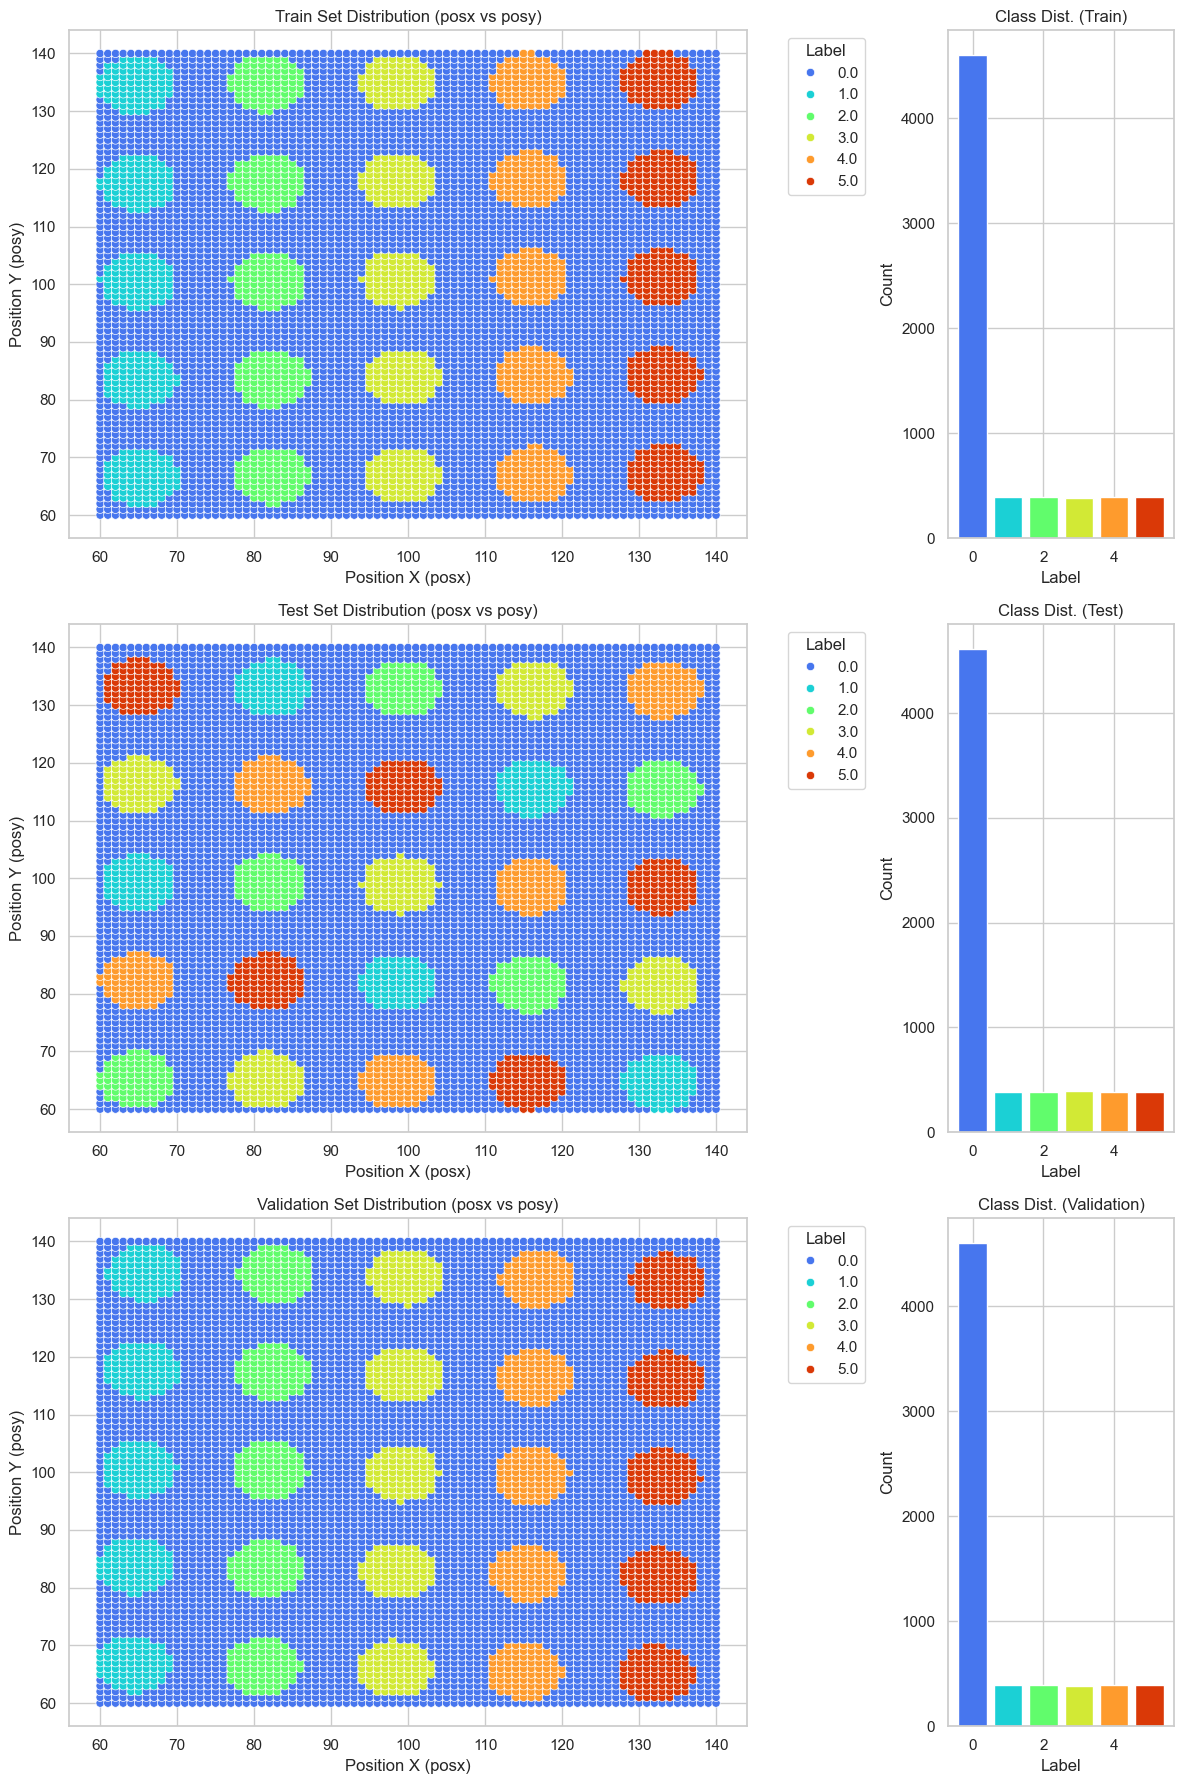

In [9]:
visualize_datasets(smoothed_train, data_test, smoothed_validation, label_column='label')

In [10]:
# Create X and y dataset with posx, posy
X_train, y_train = prepare_xy(smoothed_train, feature_list)
X_test, y_test = prepare_xy(smoothed_test, feature_list)
X_validation, y_validation = prepare_xy(smoothed_validation, feature_list)

In [11]:
# Scale dataset with posx, posy
X_train_scaled = scale_dataset(X_train, feature_list)
X_validation_scaled = scale_dataset(X_validation, feature_list)
X_test_scaled = scale_dataset(X_test, feature_list)

In [12]:
# Find points with y != 0 (not background)
hard_spots_train, y_train_hard = get_hard_spots(X_train_scaled, y_train)
hard_spots_validation, y_validation_hard = get_hard_spots(X_validation_scaled, y_validation)

### Feature Selection

In [13]:
# Global feature selection parameters
MIN_MI = 0.3
MAX_W_DIST = 0.15
MAX_W_DIST_CLASS = 0.2

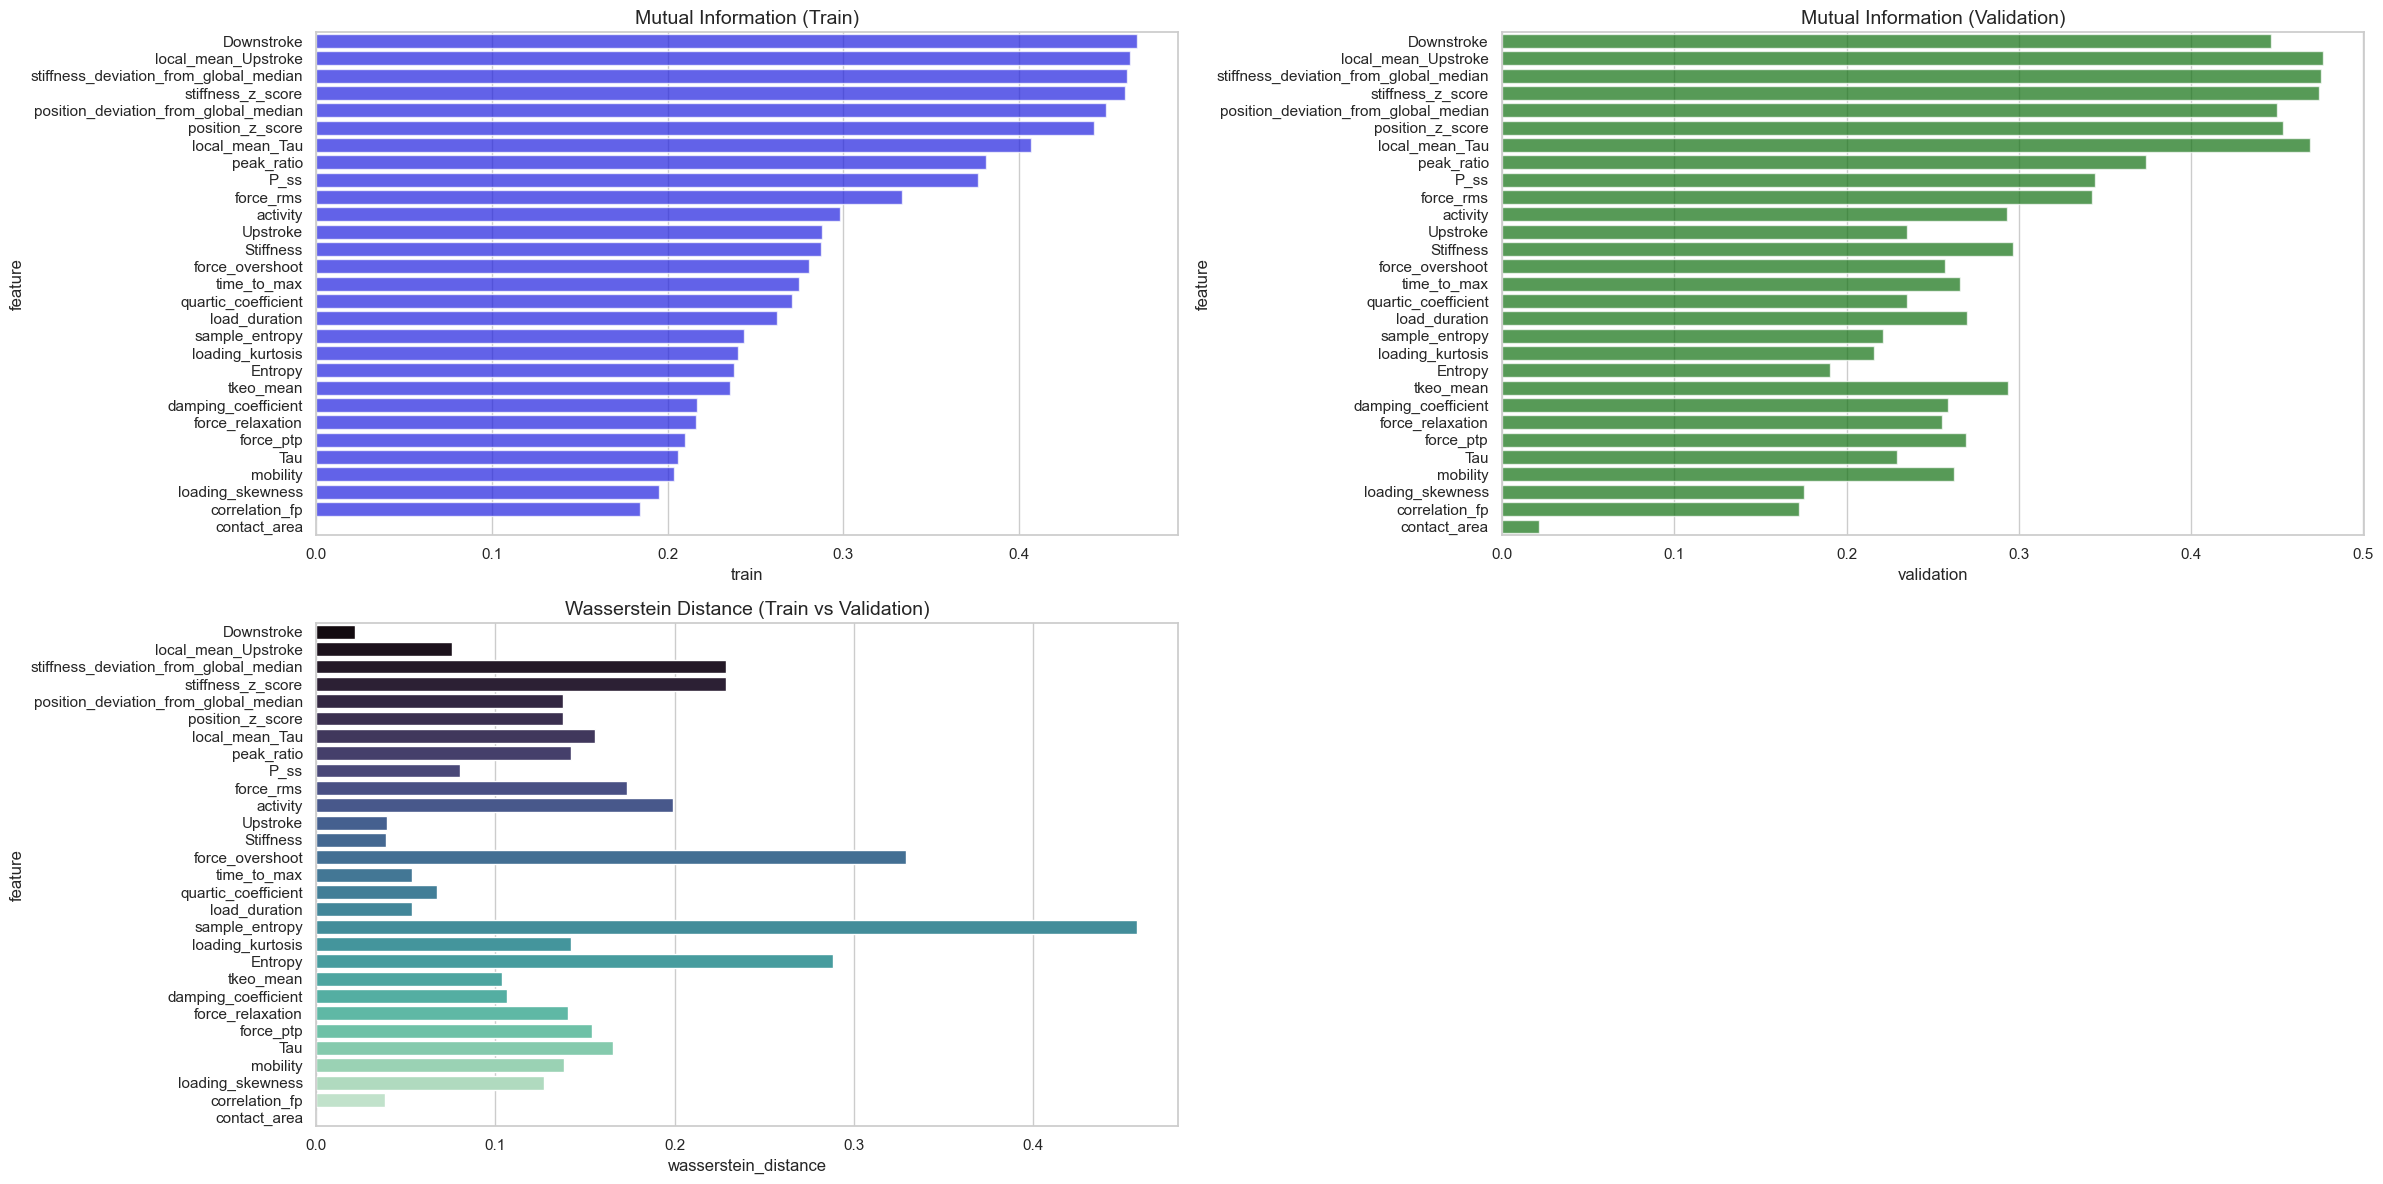

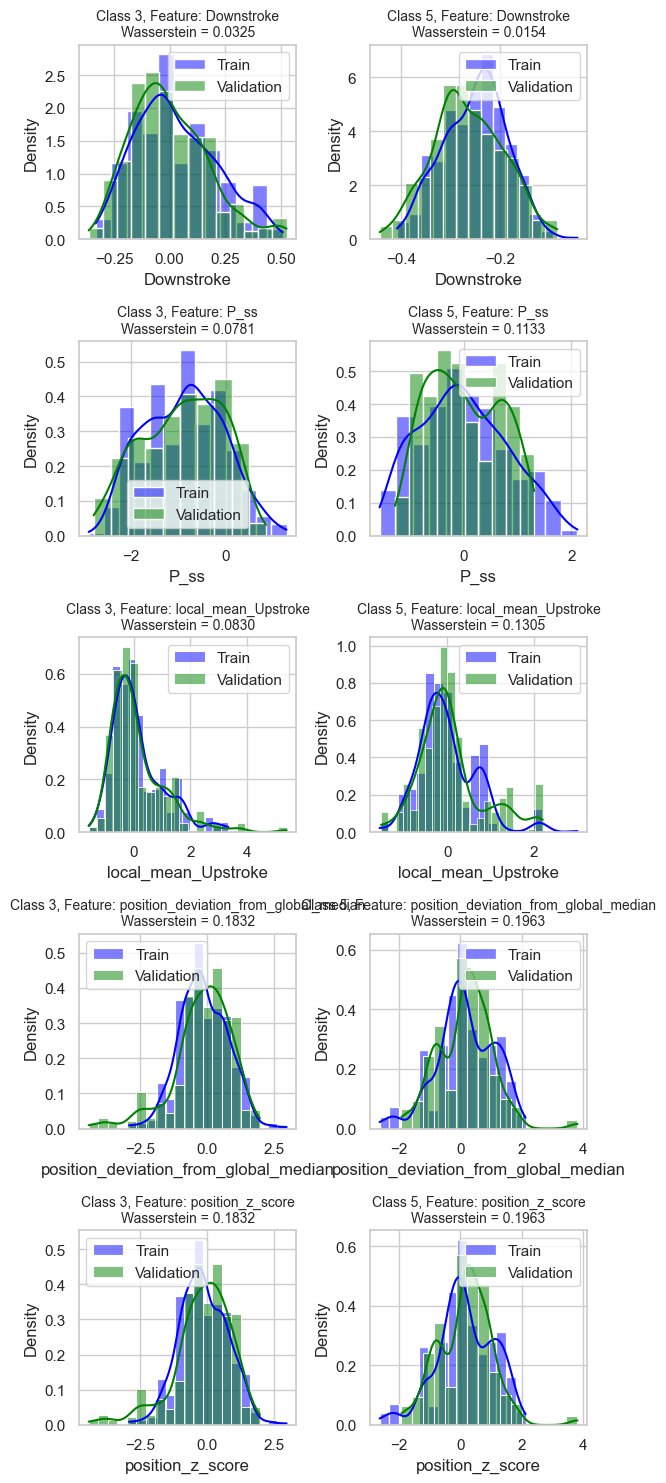

In [23]:
from featureExtraction import find_best_features

selected_features = find_best_features(
    X_train_scaled=X_train_scaled,
    y_train=y_train,
    X_validation_scaled=X_validation_scaled,
    y_validation=y_validation,
    feature_list=feature_list,
    selected_classes=[3, 5],
    mi_threshold=MIN_MI,
    wasserstein_threshold=MAX_W_DIST,
    class_wasserstein_threshold=MAX_W_DIST_CLASS,
    plot=True
)

In [29]:
wasserstein_thresholds = np.arange(0.025, MAX_W_DIST + 0.025, 0.025).tolist()
wasserstein_thresholds_per_class = np.arange(0.025, MAX_W_DIST_CLASS + 0.025, 0.025).tolist()

features_df = find_best_features_sets(
    X_train=X_train_scaled,
    y_train=y_train,
    X_validation=X_validation_scaled,
    y_validation=y_validation,
    features_to_smooth=feature_list,
    mi_th=MIN_MI,
    wasserstein_th=wasserstein_thresholds,
    wasserstein_th_per_class=wasserstein_thresholds_per_class,
    classes_to_check=[2, 3, 4, 5]
)

features_df

bandwidth: 100%|██████████| 6/6 [01:37<00:00, 16.19s/it]


w_th  w_th_c  n_features  \
0  0.050   0.100           3   
1  0.075   0.175           4   
2  0.075   0.200           6   
3  0.100   0.200           8   

                                            features  silhouette  
0                  [Stiffness, Upstroke, Downstroke]    0.212622  
1       [Stiffness, Upstroke, Downstroke, tkeo_mean]    0.197751  
2  [Stiffness, Upstroke, Downstroke, time_to_max,...    0.089662  
3  [Stiffness, Upstroke, Downstroke, time_to_max,...    0.168655

In [16]:
features_df['features'][0] = ['Stiffness', 'Upstroke', 'Downstroke', 'damping_coefficient', 'mobility', 'tkeo_mean']
features_df

C:\Users\brill\AppData\Local\Temp\ipykernel_47132\4273626488.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  features_df['features'][0] = ['Stiffness', 'Upstroke', 'Downstroke', 'damping_coefficient', 'mobility', 'tkeo_mean']
C:\Users\br

Empty DataFrame
Columns: [w_th, w_th_c, n_features, features, silhouette]
Index: []

In [30]:
all_selected_features = list(set().union(*features_df['features']))
all_selected_features

['mobility',
 'damping_coefficient',
 'load_duration',
 'Stiffness',
 'Upstroke',
 'tkeo_mean',
 'time_to_max',
 'Downstroke']

In [18]:
# Plot selected features
plot_features(pd.concat([X_train_scaled, y_train], axis=1), pd.concat([X_test_scaled, y_test], axis=1),
              all_selected_features)

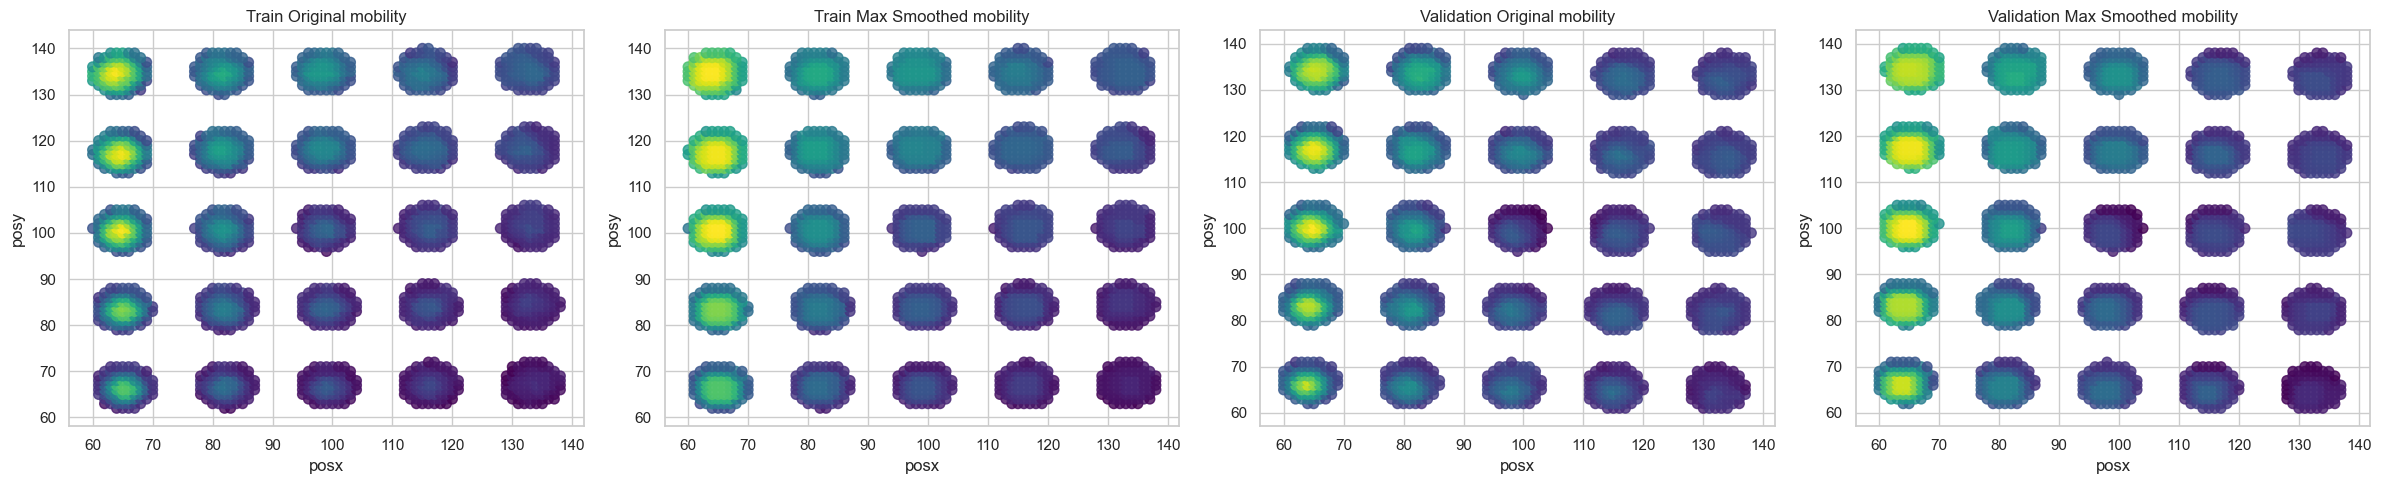

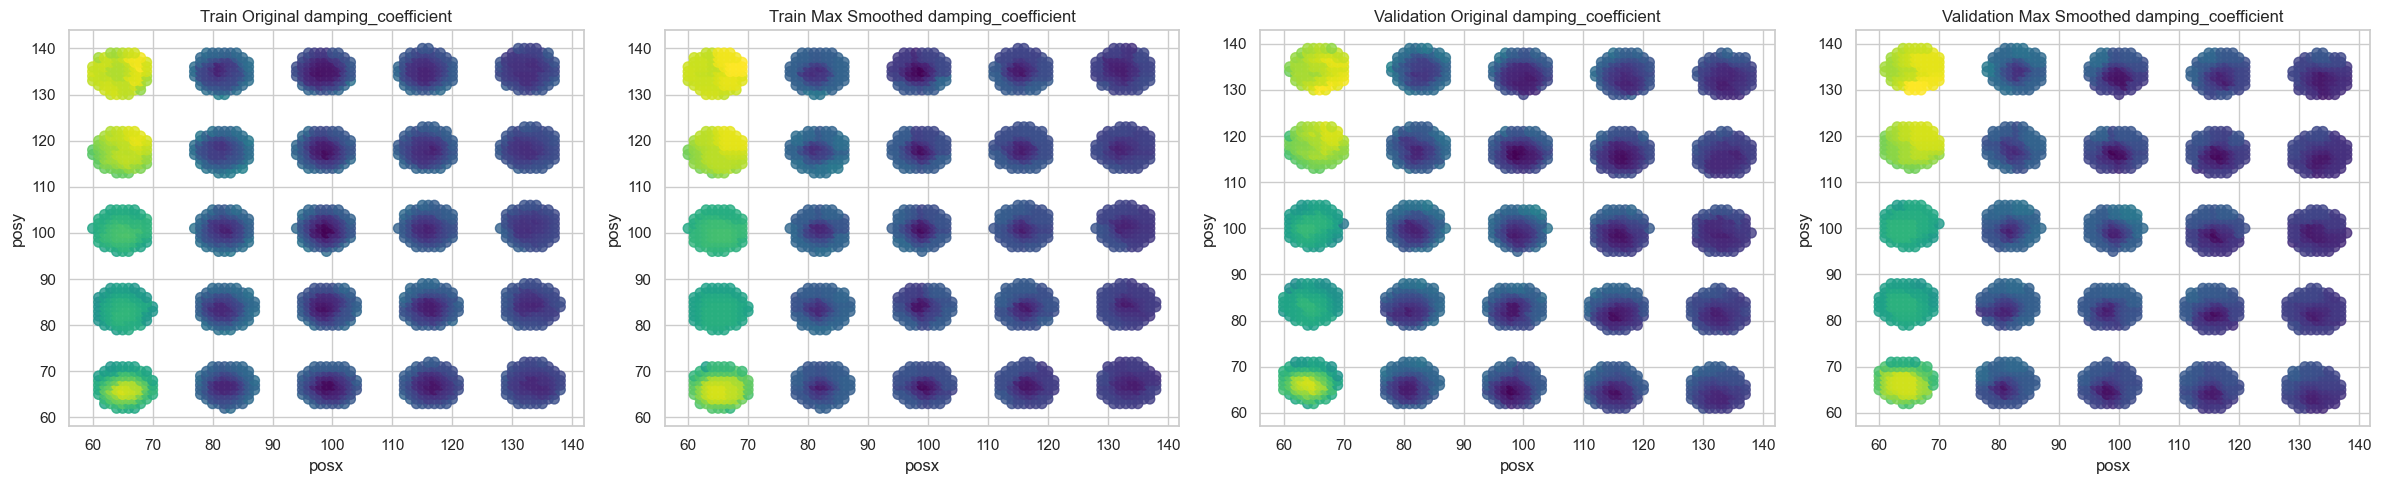

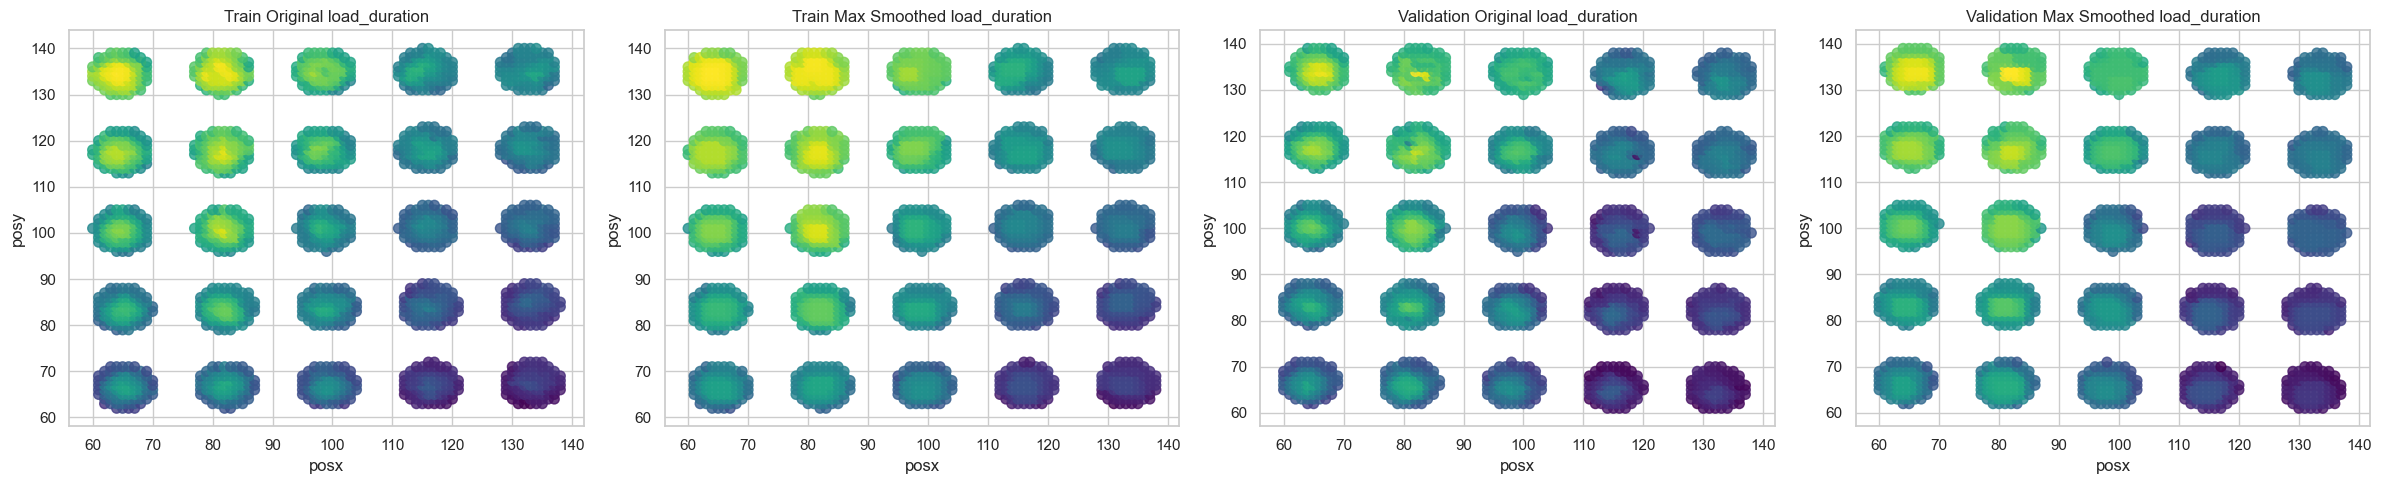

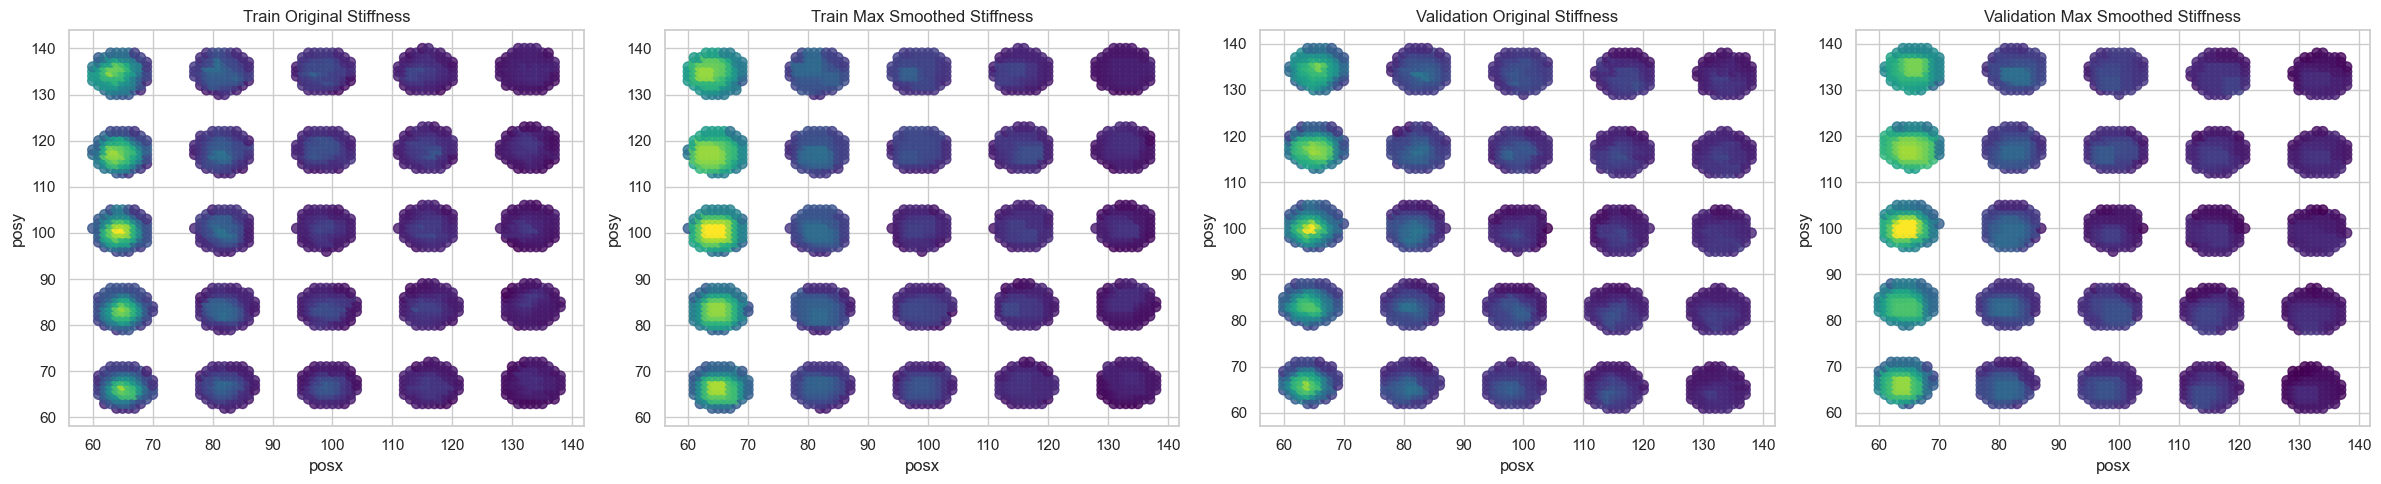

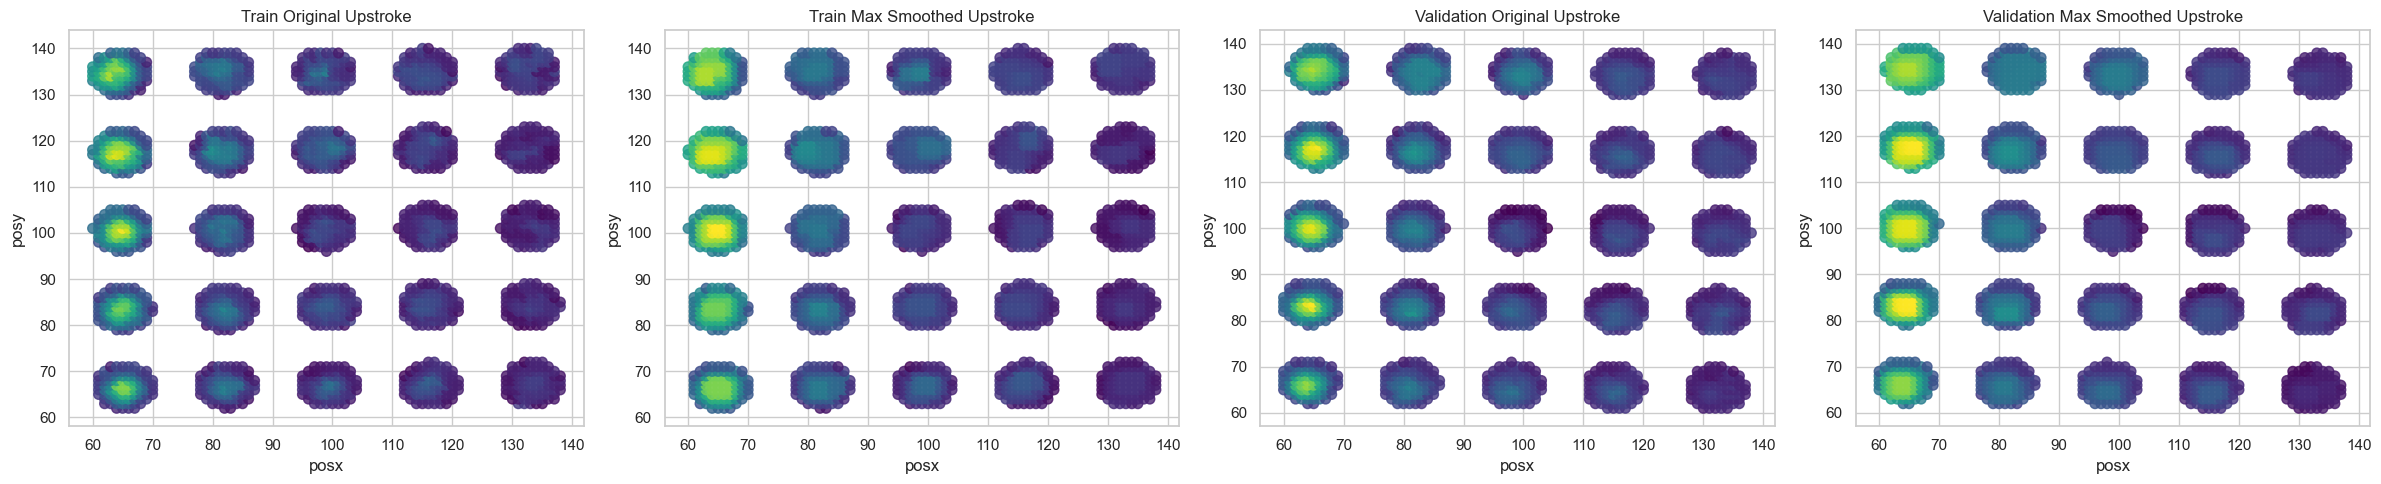

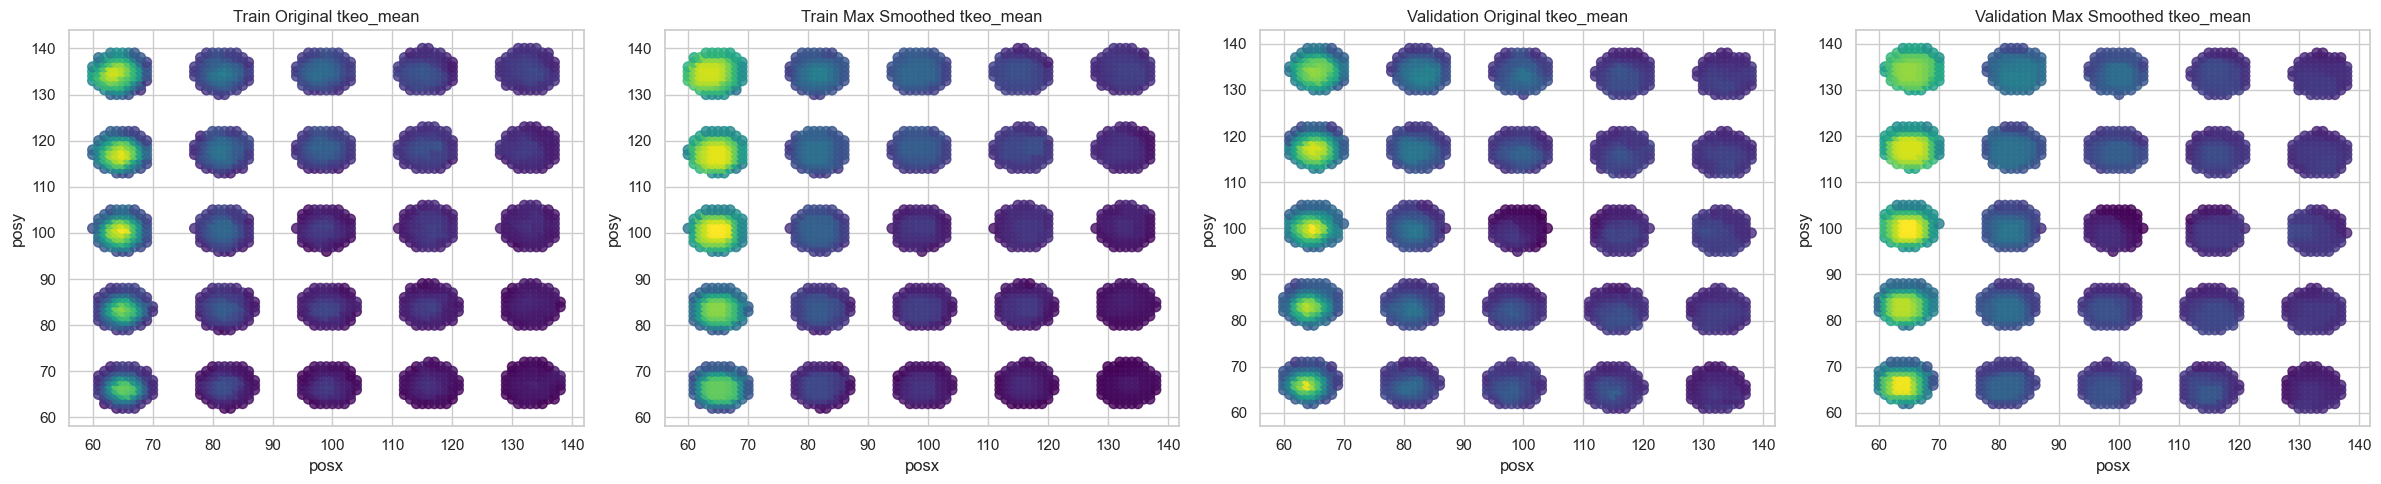

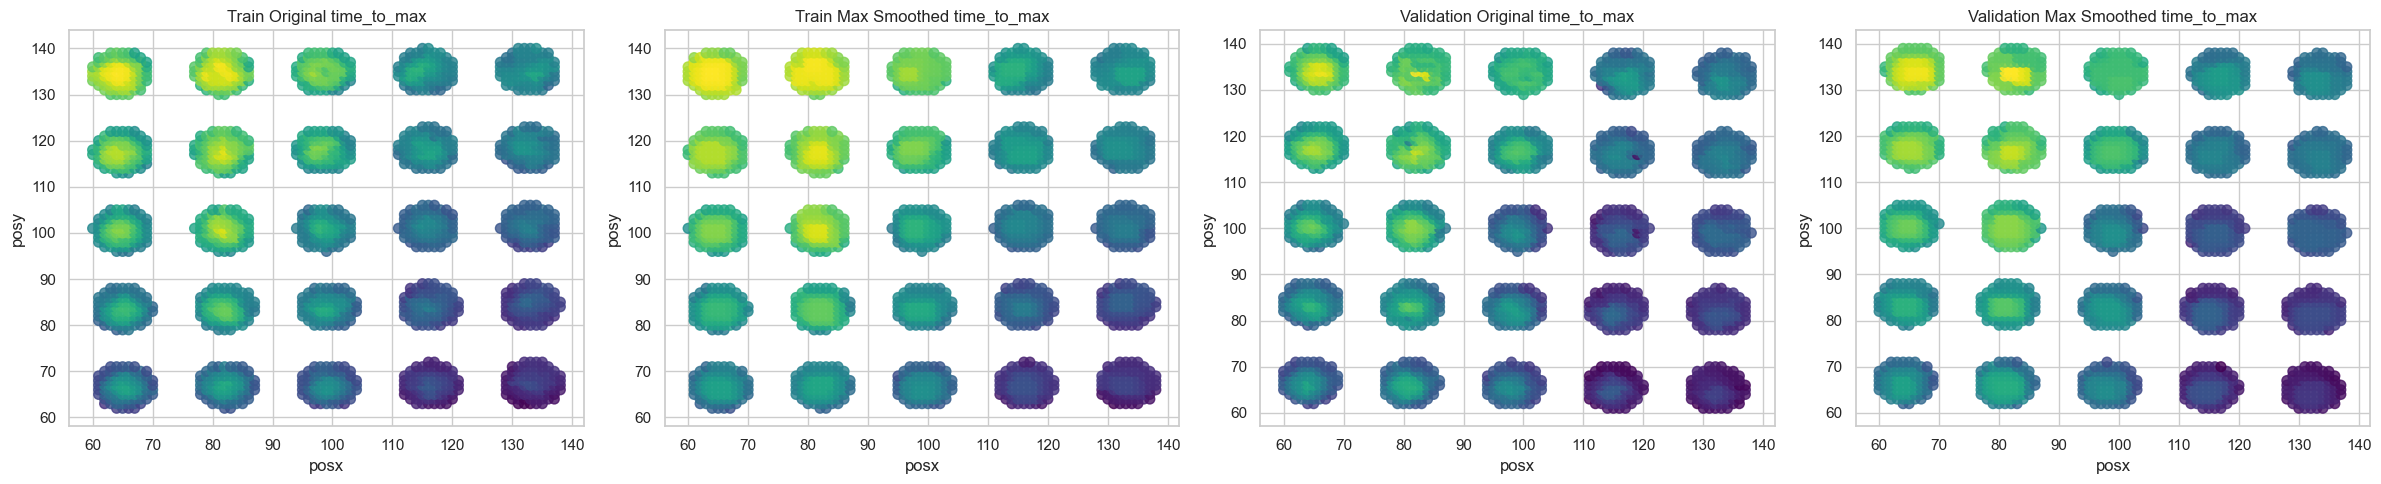

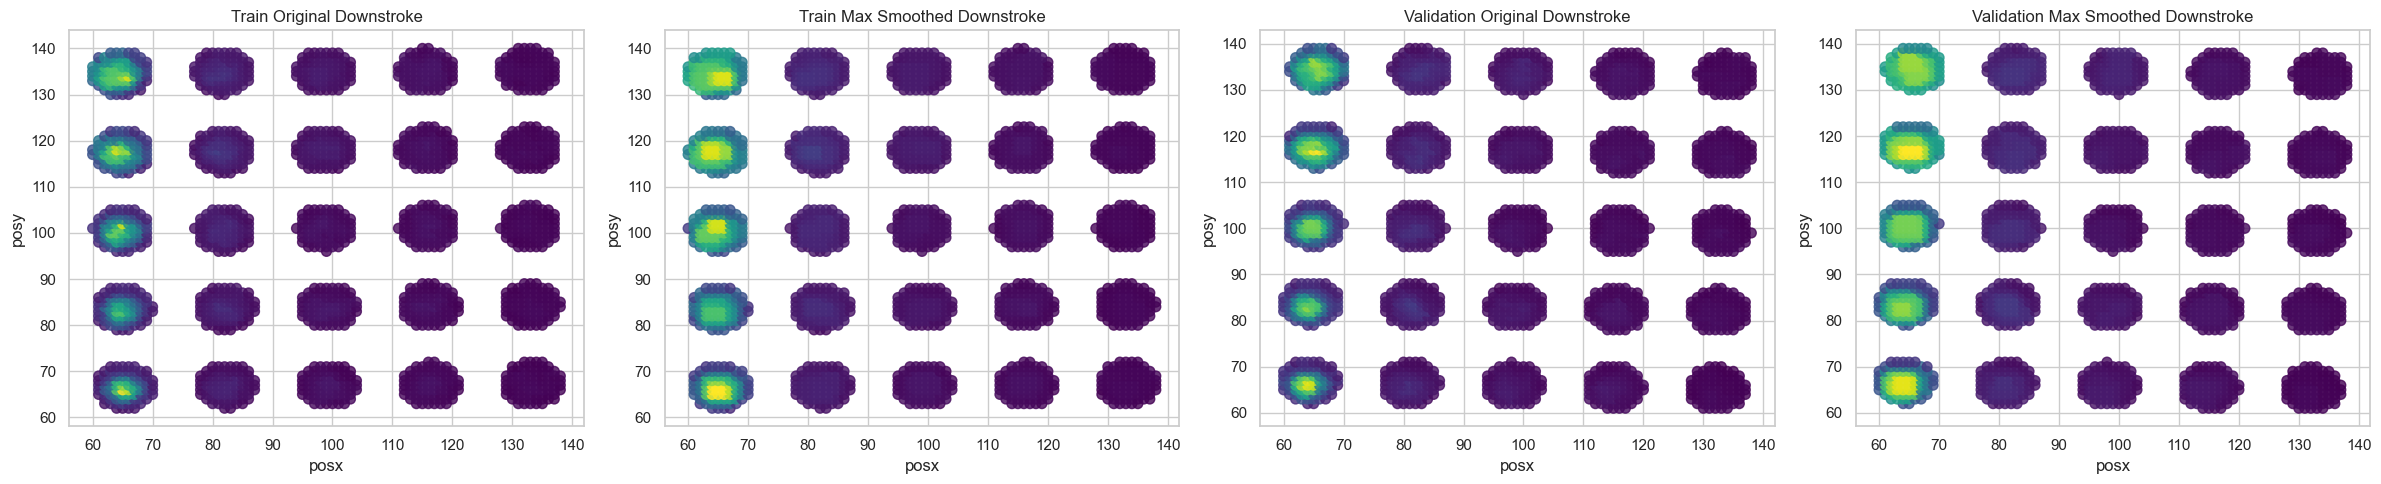

In [31]:
from smoothingHelper import grid_max_smooth
from plotter import *

# Apply 3x3 max smoothing to train set
hard_spots_train_smoothed = grid_max_smooth(
    hard_spots_train,
    all_selected_features,
)

# Apply 3x3 max smoothing to validation set
hard_spots_validation_smoothed = grid_max_smooth(
    hard_spots_validation,
    all_selected_features,
)

# # Visualize the smoothing effect for each feature
for feature in all_selected_features:
    plot_smoothing_effect(
        hard_spots_validation,
        hard_spots_validation_smoothed,
        hard_spots_train,
        hard_spots_train_smoothed,
        feature
    )


In [32]:

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# List of model hyperparameters definitions
models = [
    {
        'model': SVC(kernel='rbf', probability=True),
        'hyperparameters': {
            'C': [20, 28],
            'gamma': [0.06, 0.1, 1],
        }
    },
    {
        'model': RandomForestClassifier(n_jobs=-1, bootstrap=True, criterion='entropy', max_features=0.5,
                                        n_estimators=200),
        'hyperparameters': {
            'max_depth': [12],
            'min_samples_split': [8, 10],
            'min_samples_leaf': [5, 8]
        }
    },
    # {
    #     'model': LogisticRegression(max_iter=200),
    #     'hyperparameters': {
    #         # inverse regularization strength; smaller = stronger regularization
    #         'C': [1.0, 10.0, 15.0],
    #     }
    # },
    # {
    #     'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    #     'hyperparameters': {
    #         'n_estimators': [100, 200],
    #         # 'max_depth': [4, 6],
    #         # 'gamma': [i / 10.0 for i in range(0, 4)]
    #     }
    # }
]

# Generate the combinations
param_grid = generate_combinations(features_df, models)

In [33]:
clf = TwoStageClassifier(train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed], )

X_train_val = pd.concat([X_train_scaled, X_validation_scaled], axis=0)
y_train_val = pd.concat([y_train, y_validation], axis=0)

test_fold = [0] * len(X_train_scaled) + [1] * len(X_validation_scaled)
X_train_val['fold'] = test_fold

ps = PredefinedSplit(test_fold)

grid_search = GridSearchCV(
    clf,
    param_grid,
    scoring=make_scorer(f1_score, average='macro'),
    error_score='raise',  # stop immediately after an exception (e.g. TwoStageClassifier is badly implemented)
    cv=ps,
    n_jobs=-1,
    refit=False,  # do not retrain on whole dataset after finding the best parameters (manually done later)
    verbose=3
)

grid_search.fit(X_train_val, y_train_val)
print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Fitting 2 folds for each of 400 candidates, totalling 800 fits
Best Params: {'binary_classifier': SVC(probability=True), 'binary_classifier__C': 20, 'binary_classifier__gamma': 0.1, 'features': ['Stiffness', 'Upstroke', 'Downstroke', 'time_to_max', 'damping_coefficient', 'load_duration', 'mobility', 'tkeo_mean'], 'multiclass_classifier': SVC(probability=True), 'multiclass_classifier__C': 20, 'multiclass_classifier__gamma': 0.06}
Best Score: 0.7847963369117128



=== Test Metrics ===
Accuracy:  0.8019
F1 Score (macro):  0.5658

=== Validation Metrics ===
Accuracy:  0.8743
F1 Score (macro):  0.7538


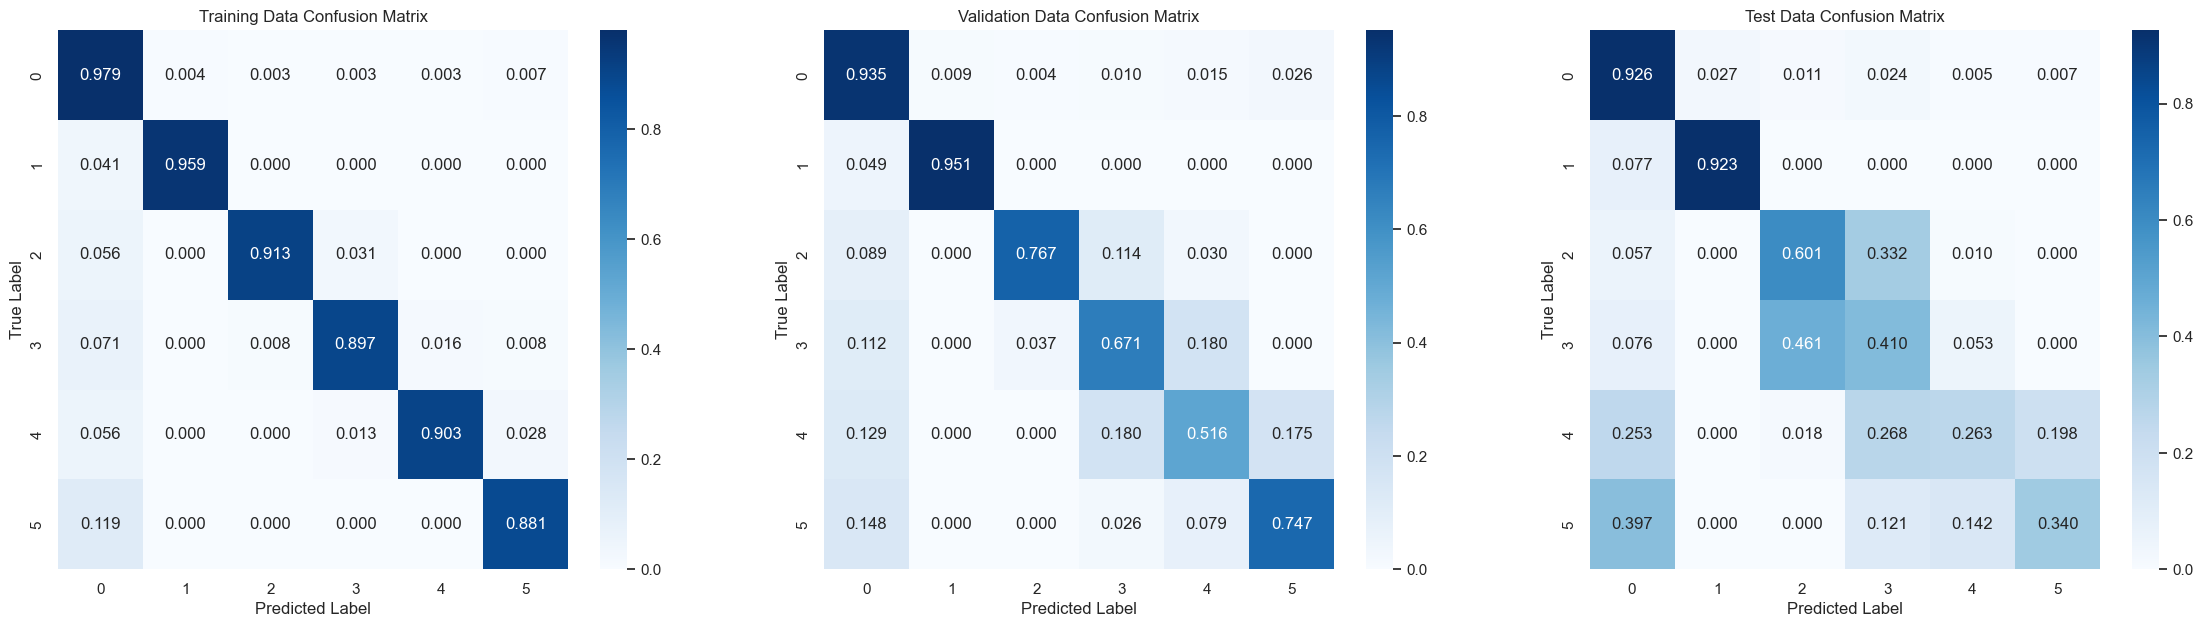

In [34]:
def print_metrics(y_true, y_pred, label="Set"):
    print(f"\n=== {label} Metrics ===")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")


# Get the best parameters
best_params = grid_search.best_params_

# Create base estimators
binary_model = clone(best_params['binary_classifier'])
multiclass_model = clone(best_params['multiclass_classifier'])
best_features = best_params['features'] + ["posx", "posy"]

# Apply parameters to the two models
for param, value in best_params.items():
    if param.startswith('binary_classifier__'):
        param_name = param.replace('binary_classifier__', '')
        setattr(binary_model, param_name, value)
    if param.startswith('multiclass_classifier__'):
        param_name = param.replace('multiclass_classifier__', '')
        setattr(multiclass_model, param_name, value)

# setattr(binary_model, 'C', 31)

# Create classifier with the configured models
best_clf = TwoStageClassifier(
    binary_classifier=binary_model,
    multiclass_classifier=multiclass_model,
    features=best_params['features'],
    train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed]
)

X_train_scaled['fold'] = [0] * len(X_train_scaled)

# Now fit and evaluate as before
best_clf.fit(X_train_scaled[best_features + ['fold']], y_train)

# Make predictions
y_pred_test = best_clf.predict(X_test_scaled[best_features])
y_pred_train = best_clf.predict(X_train_scaled[best_features])
y_pred_val = best_clf.predict(X_validation_scaled[best_features])

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 7))
plot_confusion_matrix(y_train, y_pred_train, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_validation, y_pred_val, 'Validation Data Confusion Matrix', ax2)
plot_confusion_matrix(y_test, y_pred_test, 'Test Data Confusion Matrix', ax3)

# Print performance metrics
print_metrics(y_test, y_pred_test, label="Test")
print_metrics(y_validation, y_pred_val, label="Validation")


=== Test Metrics ===
Accuracy:  0.8191
F1 Score (macro):  0.6006

=== Validation Metrics ===
Accuracy:  0.9067
F1 Score (macro):  0.8191


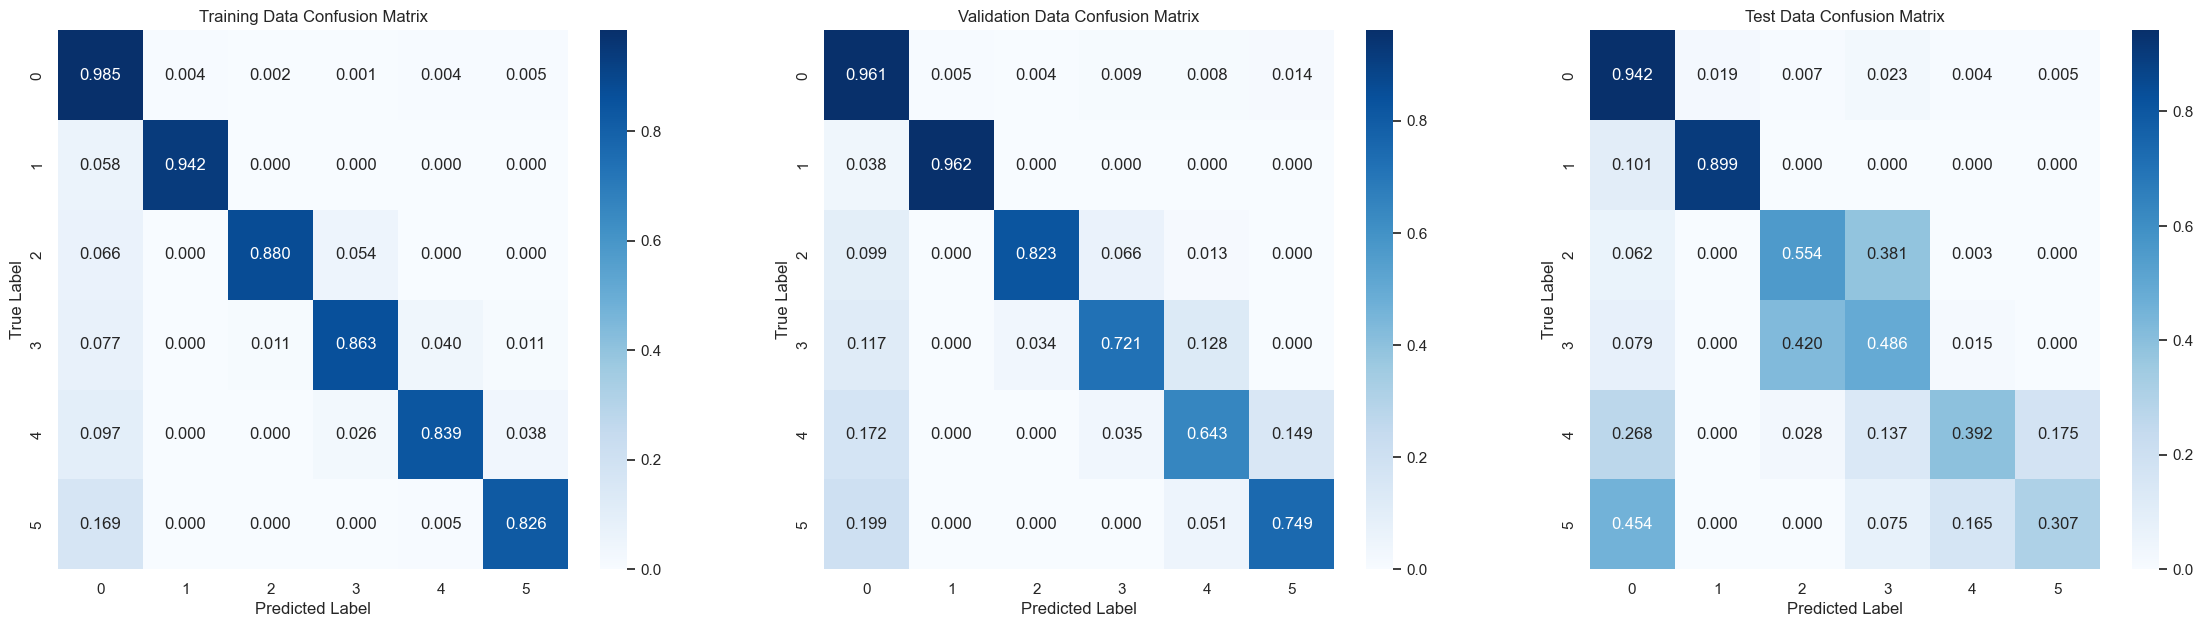

In [35]:
# train with everything
def print_metrics(y_true, y_pred, label="Set"):
    print(f"\n=== {label} Metrics ===")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score (macro):  {f1_score(y_true, y_pred, average='macro'):.4f}")


# Get the best parameters
best_params = grid_search.best_params_

# Create base estimators
binary_model = clone(best_params['binary_classifier'])
multiclass_model = clone(best_params['multiclass_classifier'])
best_features = best_params['features'] + ["posx", "posy"]

# Apply parameters to the two models
for param, value in best_params.items():
    if param.startswith('binary_classifier__'):
        param_name = param.replace('binary_classifier__', '')
        setattr(binary_model, param_name, value)
    if param.startswith('multiclass_classifier__'):
        param_name = param.replace('multiclass_classifier__', '')
        setattr(multiclass_model, param_name, value)

# setattr(binary_model, 'C', 31)

# Create classifier with the configured models
best_clf = TwoStageClassifier(
    binary_classifier=binary_model,
    multiclass_classifier=multiclass_model,
    features=best_params['features'],
    train_smoothed=[hard_spots_train_smoothed, hard_spots_validation_smoothed]
)

X_train_val['fold'] = [2] * len(X_train_val)

# Now fit and evaluate as before
best_clf.fit(X_train_val[best_features + ['fold']], y_train_val)

# Make predictions
y_pred_test = best_clf.predict(X_test_scaled[best_features])
y_pred_train = best_clf.predict(X_train_scaled[best_features])
y_pred_val = best_clf.predict(X_validation_scaled[best_features])

# Plot confusion matrices
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 7))
plot_confusion_matrix(y_train, y_pred_train, 'Training Data Confusion Matrix', ax1)
plot_confusion_matrix(y_validation, y_pred_val, 'Validation Data Confusion Matrix', ax2)
plot_confusion_matrix(y_test, y_pred_test, 'Test Data Confusion Matrix', ax3)

# Print performance metrics
print_metrics(y_test, y_pred_test, label="Test")
print_metrics(y_validation, y_pred_val, label="Validation")

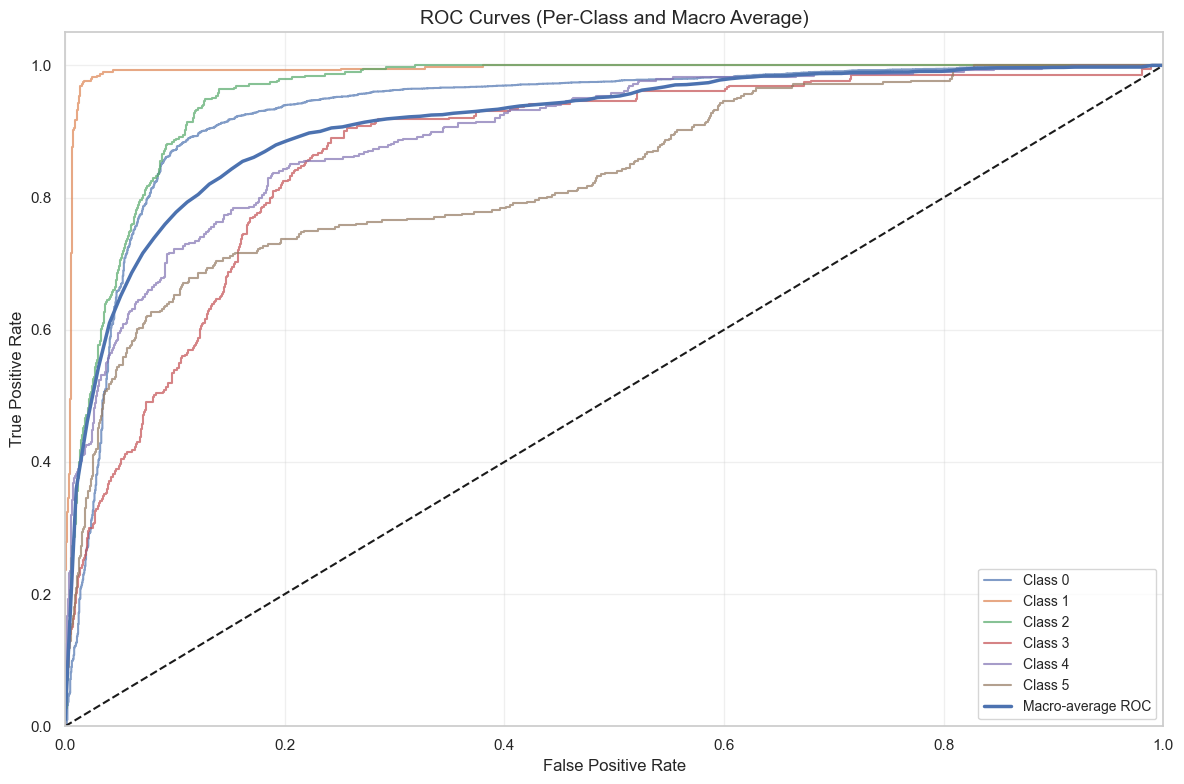

{'precision_macro': np.float64(0.61980460915707), 'recall_macro': np.float64(0.6134535252392156), 'f1_macro': np.float64(0.6053920941229737), 'precision_class_0.0': np.float64(0.9260138050043141), 'recall_class_0.0': np.float64(0.9300259965337955), 'f1_class_0.0': np.float64(0.9280155642023347), 'precision_class_1.0': np.float64(0.8434579439252337), 'recall_class_1.0': np.float64(0.9304123711340206), 'f1_class_1.0': np.float64(0.8848039215686274), 'precision_class_2.0': np.float64(0.4459016393442623), 'recall_class_2.0': np.float64(0.7010309278350515), 'f1_class_2.0': np.float64(0.5450901803607214), 'precision_class_3.0': np.float64(0.39080459770114945), 'recall_class_3.0': np.float64(0.3460559796437659), 'f1_class_3.0': np.float64(0.36707152496626183), 'precision_class_4.0': np.float64(0.5580645161290323), 'recall_class_4.0': np.float64(0.44587628865979384), 'f1_class_4.0': np.float64(0.49570200573065903), 'precision_class_5.0': np.float64(0.5545851528384279), 'recall_class_5.0': np.f

In [49]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve


def calculate_metrics(y_true, y_pred, y_proba=None):
    """Calculate and return various classification metrics"""
    metrics = {}

    # Basic metrics
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro')
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro')

    # Per class metrics
    classes = np.unique(np.concatenate([y_true, y_pred]))
    for cls in classes:
        y_true_bin = (y_true == cls).astype(int)
        y_pred_bin = (y_pred == cls).astype(int)
        metrics[f'precision_class_{cls}'] = precision_score(y_true_bin, y_pred_bin)
        metrics[f'recall_class_{cls}'] = recall_score(y_true_bin, y_pred_bin)
        metrics[f'f1_class_{cls}'] = f1_score(y_true_bin, y_pred_bin)

    # AUC if probabilities are provided
    if y_proba is not None:
        if y_proba.shape[1] > 2:  # multiclass
            # One-vs-Rest ROC AUC
            metrics['auc_macro'] = roc_auc_score(
                pd.get_dummies(y_true), y_proba, average='macro', multi_class='ovr'
            )

            # Per class AUC
            for i, cls in enumerate(sorted(np.unique(y_true))):
                if i < y_proba.shape[1]:  # Ensure we have probabilities for this class
                    y_true_bin = (y_true == cls).astype(int)
                    y_proba_bin = y_proba[:, i]
                    try:
                        metrics[f'auc_class_{cls}'] = roc_auc_score(y_true_bin, y_proba_bin)
                    except:
                        metrics[f'auc_class_{cls}'] = np.nan
        else:  # binary
            metrics['auc'] = roc_auc_score(y_true, y_proba[:, 1])

    return metrics


def plot_roc_curves(y_true, y_proba, classes):
    """Plot ROC curves for each class"""
    plt.figure(figsize=(12, 8))

    # Store FPR and TPR values for macro-averaging
    all_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(all_fpr)

    # Plot individual class ROC curves
    for i, cls in enumerate(classes):
        y_true_bin = (y_true == cls).astype(int)
        y_score = y_proba[:, i]

        fpr, tpr, _ = roc_curve(y_true_bin, y_score)

        plt.plot(fpr, tpr, lw=1.5, alpha=0.7,
                 label=f'Class {cls}')

        # Interpolate tpr values for macro-averaging
        mean_tpr += np.interp(all_fpr, fpr, tpr)

    # Calculate and plot macro-averaged ROC curve
    mean_tpr /= len(classes)

    plt.plot(all_fpr, mean_tpr, 'b-', lw=2.5,
             label=f'Macro-average ROC')

    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

    # Configure the plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves (Per-Class and Macro Average)', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


y_proba = best_clf.predict_proba(X_test_scaled[best_features])
plot_roc_curves(y_test, y_proba, [0, 1, 2, 3, 4, 5])

print(calculate_metrics(y_test, y_pred_test, y_proba))


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\brill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\brill\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\traitlets\config\application.py", line 1075, in launch

AttributeError: _ARRAY_API not found

  0%|          | 0/66 [00:00<?, ?it/s]

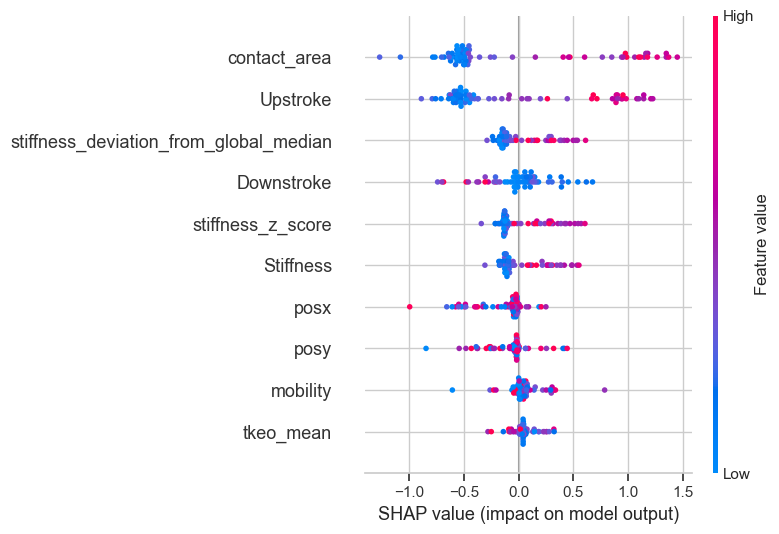

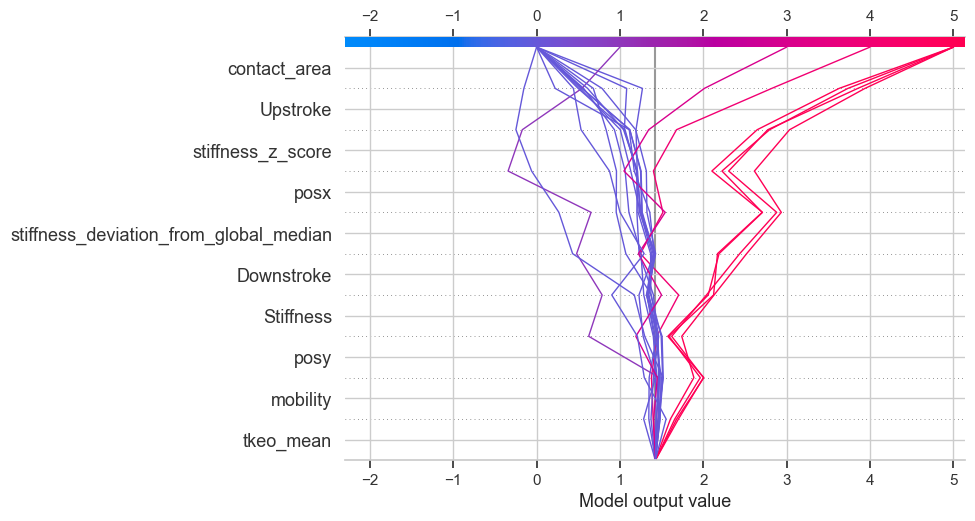

In [64]:
# import shap
# import pandas as pd
# import numpy as np
#
# # -------------------------------------------------------------------
# # 1) Prepare: feature list & background
# # -------------------------------------------------------------------
#
# bg_df = X_train_scaled[best_features].sample(frac=0.01, random_state=38)
# bg_np = bg_df.to_numpy()
#
#
# # -------------------------------------------------------------------
# # 2) Wrap predict to accept NumPy arrays
# # -------------------------------------------------------------------
#
# def wrapped_predict(arr):  # because it uses np array by default
#     df = pd.DataFrame(arr, columns=best_features)
#     return best_clf.predict(df)
#
#
# # -------------------------------------------------------------------
# # 3) Create SHAP KernelExplainer and compute values
# # -------------------------------------------------------------------
#
# explainer = shap.KernelExplainer(wrapped_predict, bg_np)
# # test_np   = X_test_final[best_features].to_numpy()
# test_sample = X_test_scaled[best_features].sample(frac=0.1, random_state=42)
# test_np = test_sample.to_numpy()
#
# # nsamples trades off speed vs. accuracy
# shap_values = explainer.shap_values(test_np)
#
# # -------------------------------------------------------------------
# # 4) Plot the SHAP summary plot
# # -------------------------------------------------------------------
#
# shap.summary_plot(
#     shap_values,
#     test_np,
#     feature_names=best_features
# )
#
# # Select a subset of samples (e.g., first 20)
# sample_idxs = list(range(20))
#
# # Decision plot for multiple samples
# shap.plots.decision(
#     base_value=explainer.expected_value,
#     shap_values=shap_values[sample_idxs],
#     features=test_np[sample_idxs],
#     feature_names=best_features
# )
#
# # Optional: Grouped force plot
# shap.initjs()
# shap.plots.force(
#     explainer.expected_value,
#     shap_values[sample_idxs],
#     test_np[sample_idxs],
#     feature_names=best_features
# )
